In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# from google.colab import drive
# drive.mount('/content/drive')

import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('/final_df.csv').drop('Unnamed: 0', axis = 1) # "CPI" (Consumer Price Index) of 211.1, for example, Indicates that, on Average, Overall Product Prices have Increased by 111.1% since the Base Year
df.columns = df.columns.str.replace('_', '')

df.head(8)

,Store,Date,Temperature,FuelPrice,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Dept,WeeklySales,Type,Size,StoreSizeCategory,Month,Day of Month,Year
0,1,05/02/2010,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,1.0,24924.50,A,151315.0,Above Average Size,Feb,5.0,2010.0
1,1,05/02/2010,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,2.0,50605.27,A,151315.0,Above Average Size,Feb,5.0,2010.0
2,1,05/02/2010,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,3.0,13740.12,A,151315.0,Above Average Size,Feb,5.0,2010.0
3,1,05/02/2010,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,4.0,39954.04,A,151315.0,Above Average Size,Feb,5.0,2010.0
4,1,05/02/2010,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,5.0,32229.38,A,151315.0,Above Average Size,Feb,5.0,2010.0
5,1,05/02/2010,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,6.0,5749.03,A,151315.0,Above Average Size,Feb,5.0,2010.0
6,1,05/02/2010,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,7.0,21084.08,A,151315.0,Above Average Size,Feb,5.0,2010.0
7,1,05/02/2010,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,8.0,40129.01,A,151315.0,Above Average Size,Feb,5.0,2010.0


## Time Series Analysis & Forecasting

In [ ]:
# Preprocessing the Data
# Need a Better, more-Appropriate-to-Prophet "datetime" column for Monthly Forecasting

df['Date'] = pd.to_datetime(df['Date'], format = '%d/%m/%Y')
df['Month'] = df['Date'].dt.to_period('M').dt.to_timestamp() # Prophet needs this Standardized, Proper Timestamp for Usage

In [ ]:
# Aggregating Weekly Sales by Month to get Overall Weekly Sales per Month
monthly_df = df.groupby('Month')['WeeklySales'].sum().reset_index()

# Renaming Columns for Time Series Forecasting using Meta's "Prophet"
df_proph = monthly_df.rename(columns = {'Month': 'ds', 'WeeklySales': 'y'})

## Time Series Forecasting using Meta's *Prophet*

In [ ]:
# Fitting the "Prophet" Time Series Model
from prophet import Prophet

m = Prophet()
m.fit(df_proph)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp66rfs4pc/5cs1st22.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp66rfs4pc/x3f79ctx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25779', 'data', 'file=/tmp/tmp66rfs4pc/5cs1st22.json', 'init=/tmp/tmp66rfs4pc/x3f79ctx.json', 'output', 'file=/tmp/tmp66rfs4pc/prophet_model4ab_xswo/prophet_model-20251003051458.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
05:14:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:14:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
# Creating the Future DataFrame (next 18 Months of Forecasts; 6 Quarters)
future = m.make_future_dataframe(periods = 18, freq = 'M') # Monthly Forecasts
forecast = m.predict(future)

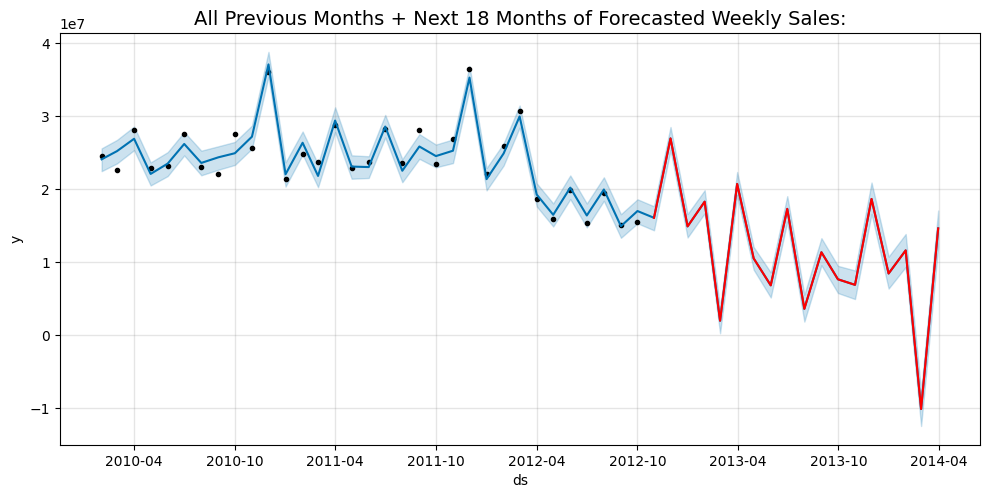

In [ ]:
# Let's Plot the Forecast!

m.plot(forecast, figsize = (10, 5))
plt.plot(forecast[forecast['ds'] > df_proph['ds'].max()]['ds'],
         forecast[forecast['ds'] > df_proph['ds'].max()]['yhat'], color = 'red') # The Forecasted Trends for the Next 12 Months

plt.title("All Previous Months + Next 18 Months of Forecasted Weekly Sales:", fontsize = 14)
plt.show()

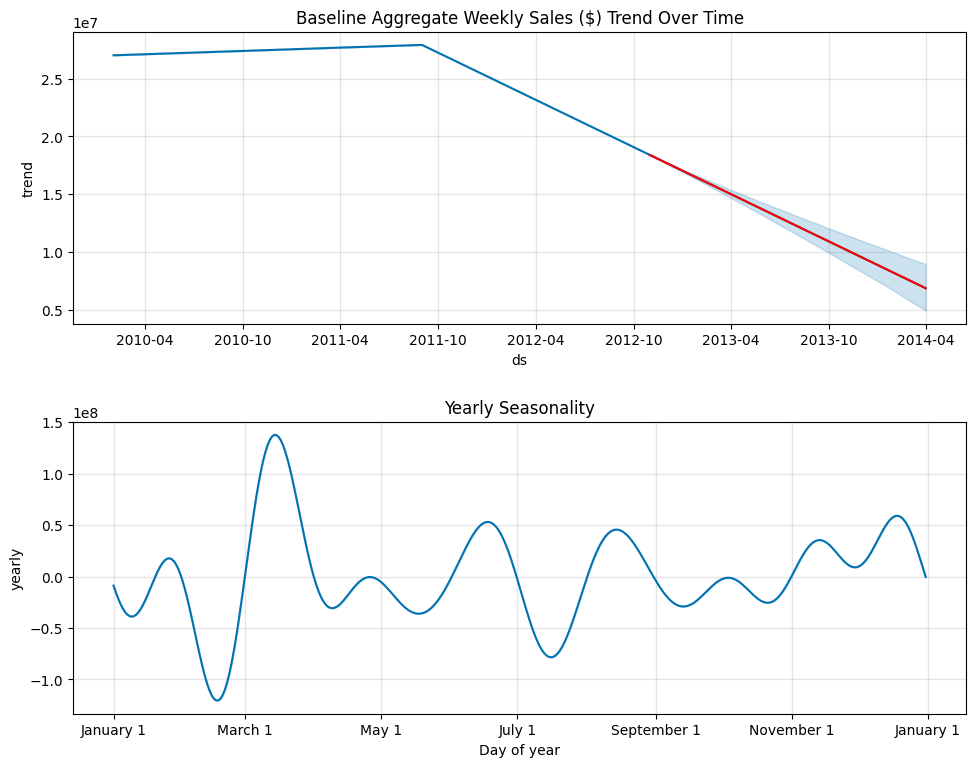

In [ ]:
# Preparing to Plot the Components too (Trend & Seasonality)

from prophet.plot import plot_components

fig = plot_components(m, forecast)

axes = fig.get_axes()

# The Plots Themselves!
axes[0].set_title('Baseline Aggregate Weekly Sales ($) Trend Over Time')
axes[0].plot(forecast[forecast['ds'] > df_proph['ds'].max()]['ds'],
             forecast[forecast['ds'] > df_proph['ds'].max()]['trend'],
             label = 'Forecasted Trend', color = 'red') # Smooths out Seasonal and Irregular Fluctuations and so will be Different from the Overall Forecast ("m.plot()")

axes[1].set_title('Yearly Seasonality')

# Tuning
fig.set_size_inches(10, 8)
plt.show()

# First Graph: "Overall Baseline Weekly Sales Trend over Time - Month-to-Month"
# Second Graph: "Seasonality-based Weekly Sales Trend Across the Year"

In [ ]:
# Comparing Actual & Predicted Values from "Prophet" (NOT Including Forecasted Future Values)

art_df = pd.merge(monthly_df, forecast, left_on = 'Month', right_on = 'ds', how = 'inner').reset_index(drop = True)

# Calculating Raw Differences
art_df['Diff'] = (art_df['WeeklySales'] - art_df['yhat']).round(2)

# 'yhat' = Forecasted and Future-Predicted Total Monthly Sales
# 'y' = Actual Historical Sum of Total Monthly Sales
# 'ds' = Datestamp ('Month", in this case, in Datetime format) used for the Time Series

# % Differences
art_df['Diff %'] = round(((art_df['WeeklySales'] - art_df['yhat']) / art_df['WeeklySales']) * 100, 2)

# Let's View
display(art_df[['Month', 'ds', 'WeeklySales', 'yhat', 'Diff', 'Diff %']].head(6))

,Month,ds,WeeklySales,yhat,Diff,Diff %
0,2010-02-01,2010-02-01,24581930.46,2.406990e+07,512027.67,2.08
1,2010-03-01,2010-03-01,22609090.36,2.519314e+07,-2584046.00,-11.43
2,2010-04-01,2010-04-01,28107631.70,2.688399e+07,1223641.19,4.35
3,2010-05-01,2010-05-01,22822367.62,2.207096e+07,751405.75,3.29
4,2010-06-01,2010-06-01,23177431.53,2.348405e+07,-306616.65,-1.32
5,2010-07-01,2010-07-01,27582121.66,2.617284e+07,1409278.63,5.11


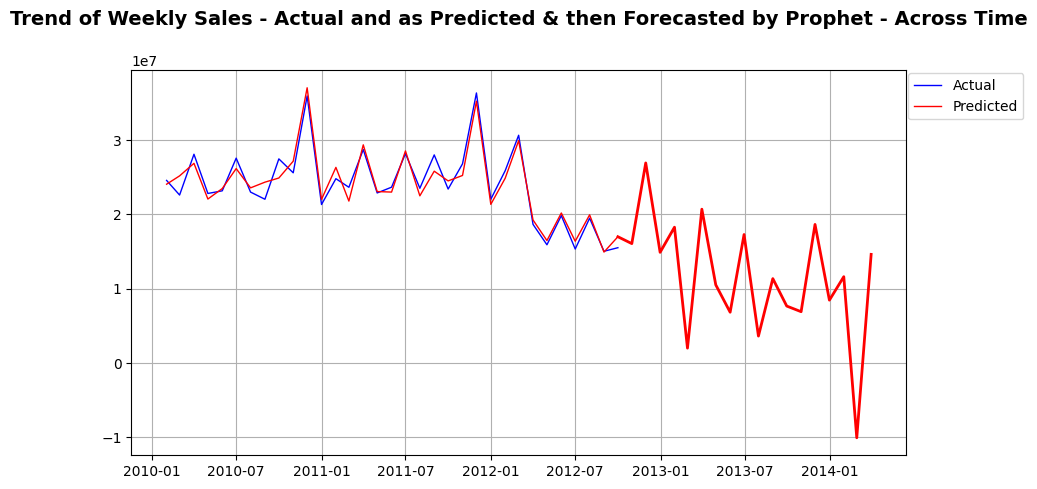

In [ ]:
# Overall Trends of Weekly Sales ($): Actual, and as Forecasted by Prophet, Displayed for Inspection, Analysis, and Decision-Making

plt.figure(figsize = (10, 5))

plt.plot(art_df['Month'], art_df['WeeklySales'], c = 'blue', linewidth = 1)
plt.plot(art_df['ds'], art_df['yhat'], c = 'red', linewidth = 1) # Predicted
plt.plot(forecast[forecast['ds'] >= df_proph['ds'].max()]['ds'], forecast[forecast['ds'] >= df_proph['ds'].max()]['yhat'], c = 'red', linewidth = 2) # The Forecasted Trends for the Next 12 Months

plt.title("Trend of Weekly Sales - Actual and as Predicted & then Forecasted by Prophet - Across Time\n", fontweight = 'bold', fontsize = 14)
plt.legend(['Actual', 'Predicted'], bbox_to_anchor = (1.16, 1.01))
plt.grid(True)
plt.show()

^We can see that the Predicted Sales are quite Close to Actual ones, and Display a similar trend into the future as well.

In [ ]:
# DataFrame of Only Forecasted Future Values
preds_only = forecast.loc[forecast['ds'] > df['Date'].max()]

# Rolling % Change in Time Series Forecasted Weekly Sales
preds_only['yhat_pct_change'] = preds_only['yhat'].pct_change() * 100

# Let's View
display(preds_only[['ds', 'yhat', 'yhat_pct_change']].head(6))

,ds,yhat,yhat_pct_change
33,2012-10-31,1.606359e+07,NaN
34,2012-11-30,2.693603e+07,67.683731
35,2012-12-31,1.488995e+07,-44.721075
36,2013-01-31,1.827316e+07,22.721404
37,2013-02-28,1.973715e+06,-89.198828
38,2013-03-31,2.070371e+07,948.971780


# The **Dynamic Pricing Model**:

# Plan
To develop a Dynamic Pricing Model for each Month in the Future based on the Prophet model's Time Series Forecast, where the model suggests a percentage price change for each future Month based on the Month-over-Month Percentage Change in Forecasted Weekly Sales.

The Dynamic Pricing Suggestion for each Month can be Scaled to apply to each Store by its *Size*.

Then, the Store management can further adjust Pricing within specific Departments using more Detailed and Niche metrics available only to them - that sort of super-specific analysis is beyond the scope of this project and may be left to the Stores' teams to do.

## Inspect forecasted sales changes

### Subtask:
Examine the `preds_only` dataframe to understand the month-over-month percentage change in forecasted weekly sales.


**Reasoning**:
Display the `preds_only` DataFrame to review its columns and the calculated `yhat_pct_change`, and then focus on the relevant columns and analyze the range and distribution of the percentage changes.



,ds,WeeklySales,yhat,yhat_pct_change
0,2010-02-01,24581930.46,2.406990e+07,NaN
1,2010-03-01,22609090.36,2.519314e+07,4.67
2,2010-04-01,28107631.70,2.688399e+07,6.71
3,2010-05-01,22822367.62,2.207096e+07,-17.90
4,2010-06-01,23177431.53,2.348405e+07,6.40
5,2010-07-01,27582121.66,2.617284e+07,11.45
6,2010-08-01,23008009.48,2.357648e+07,-9.92



Descriptive Statistics for "yhat_pct_change":


,yhat_pct_change
count,50.00
mean,16.57
std,151.60
min,-244.56
25%,-24.24
50%,2.65
75%,21.38
max,948.97


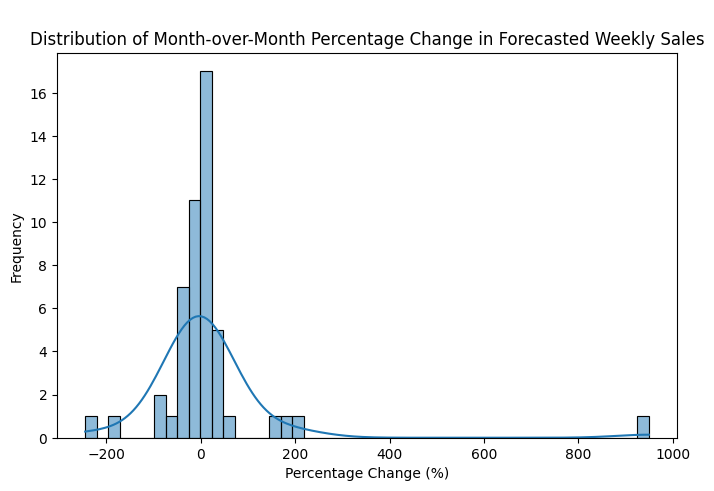

In [ ]:
# Selecting the Relevant Columns - Will Calculate and Use % Changes for Historical as well as Predicted Future Dates
art_df2 = pd.merge(monthly_df, forecast, left_on = 'Month', right_on = 'ds', how = 'outer').reset_index(drop = True)
art_df2['yhat_pct_change'] = round(art_df2['yhat'].pct_change()*100, 2)
preds_analysis = art_df2[['ds', 'WeeklySales', 'yhat', 'yhat_pct_change']]

# Displaying the Relevant Columns
display(preds_analysis.head(7))

# Analyzing the Range and Distribution of "yhat_pct_change"
print("""\nDescriptive Statistics for "yhat_pct_change":""")
display(preds_analysis['yhat_pct_change'].describe().round(2))

plt.figure(figsize = (8, 5))
sns.histplot(preds_analysis['yhat_pct_change'].dropna(), kde = True)
plt.title('\nDistribution of Month-over-Month Percentage Change in Forecasted Weekly Sales')
plt.xlabel('Percentage Change (%)')
plt.ylabel('Frequency')
plt.show()

## Define pricing strategy

### Subtask:
Determine how the percentage change in forecasted sales will translate into a suggested percentage change in price.


**Reasoning**:
Define a function to map the percentage change in forecasted sales to a suggested percentage price change using a piecewise linear function with thresholds.



In [ ]:
print(preds_analysis.yhat_pct_change.describe(percentiles = [0.2, 0.4, 0.6, 0.8, 1]))

count     50.00000
mean      16.56840
std      151.59625
min     -244.56000
20%      -35.23800
40%       -9.92400
50%        2.65000
60%        7.66600
80%       22.99600
100%     948.97000
max      948.97000
Name: yhat_pct_change, dtype: float64


In [ ]:
def suggest_price_change(yhat_pct_change, quantiles):
    """
    Suggests a percentage price change based on the percentage change in forecasted weekly sales.

    Args:
        yhat_pct_change: The month-over-month percentage change in forecasted weekly sales (a single float).
        quantiles: A dictionary or Series containing the pre-calculated quantiles of the yhat_pct_change Series.

    Returns:
        The suggested percentage price change.
    """
    if yhat_pct_change >= quantiles[0.8]:
        # Significant increase in forecasted sales, suggest a price increase
        return 10  # Suggest 10% price increase
    elif yhat_pct_change >= quantiles[0.5]:
        # Moderate increase, suggest a smaller price increase
        return 2 # 2% Price Increase
    elif yhat_pct_change <= quantiles[0.4]:
        # In the Zone of Percent Decreases; suggest a price decrease
        return -2 # 2% Price Decrease
    elif yhat_pct_change <= quantiles[0.3]:
        # Moderate decrease, suggest a smaller price decrease
        return -8 # 8% Price Decrease
    else:
        # Small change, no price change
        return 0

# Calculate quantiles beforehand
pct_change_quantiles = preds_analysis['yhat_pct_change'].quantile([0.3, 0.4, 0.5, 0.8])

# Applying the Function to the "preds_analysis" DataFrame
preds_analysis['suggested_price_change'] = preds_analysis['yhat_pct_change'].apply(suggest_price_change, quantiles = pct_change_quantiles)

# Displaying the Results
display(preds_analysis[['ds', 'yhat', 'yhat_pct_change', 'suggested_price_change']].head())
display(preds_analysis['suggested_price_change'].value_counts())

# Documenting the chosen strategy
print("\nChosen Strategy: Piecewise Linear Function with Thresholds")
print("Rationale: This approach uses predefined thresholds based on quantiles of the forecasted sales change.")
print("Based on these categories, a fixed percentage price change is suggested.")
print("Parameters:")
print(f"- If yhat_pct_change >= {pct_change_quantiles[0.8]:.2f}%: Suggest 10% price increase")
print(f"- If {pct_change_quantiles[0.5]:.2f}% <= yhat_pct_change < {pct_change_quantiles[0.8]:.2f}%: Suggest 2% price increase")
print(f"- If {pct_change_quantiles[0.4]:.2f}% >= yhat_pct_change > {pct_change_quantiles[0.3]:.2f}% : Suggest -1% price decrease")
print(f"- If yhat_pct_change <= {pct_change_quantiles[0.3]:.2f}%: Suggest -10% price decrease")
print(f"- Otherwise: Suggest 0% price change (between {pct_change_quantiles[0.4]:.2f}% and {pct_change_quantiles[0.5]:.2f}%)")

,ds,yhat,yhat_pct_change,suggested_price_change
0,2010-02-01,2.406990e+07,NaN,0
1,2010-03-01,2.519314e+07,4.67,2
2,2010-04-01,2.688399e+07,6.71,2
3,2010-05-01,2.207096e+07,-17.90,-2
4,2010-06-01,2.348405e+07,6.40,2


,count
suggested_price_change,
-2,20
2,15
10,10
0,6



Chosen Strategy: Piecewise Linear Function with Thresholds
Rationale: This approach uses predefined thresholds based on quantiles of the forecasted sales change.
Based on these categories, a fixed percentage price change is suggested.
Parameters:
- If yhat_pct_change >= 23.00%: Suggest 10% price increase
- If 2.65% <= yhat_pct_change < 23.00%: Suggest 2% price increase
- If -9.92% >= yhat_pct_change > -19.56% : Suggest -1% price decrease
- If yhat_pct_change <= -19.56%: Suggest -10% price decrease
- Otherwise: Suggest 0% price change (between -9.92% and 2.65%)


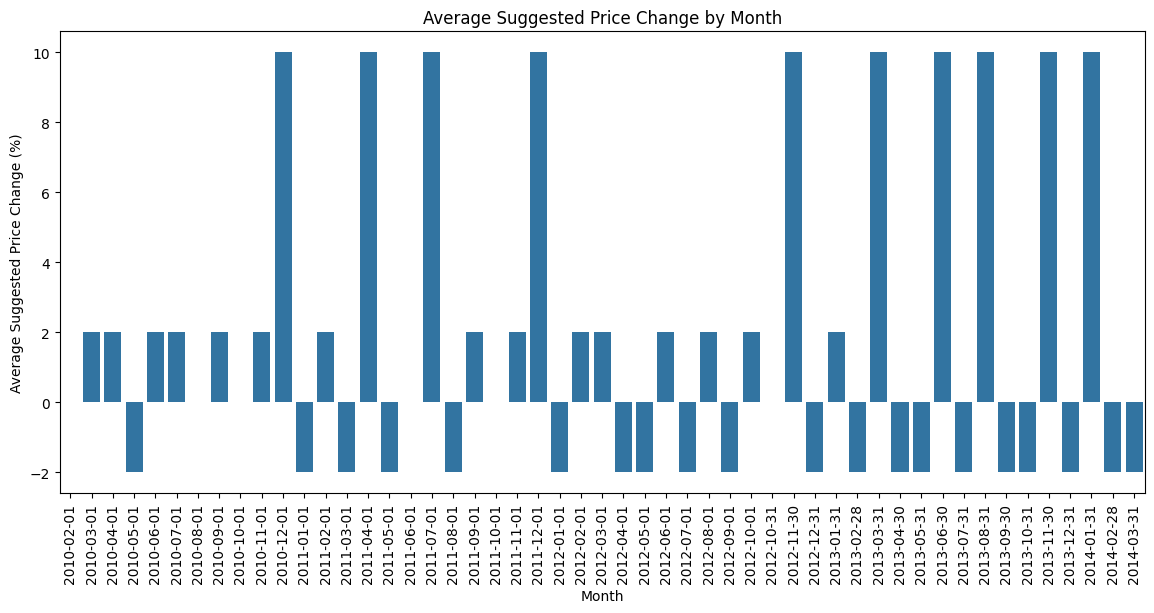

In [ ]:
# preds_analysis['Month'] = preds_analysis['ds'].dt.month
# preds_analysis['Month']

plt.figure(figsize = (14, 6))

sns.barplot(x = preds_analysis.groupby('ds')['suggested_price_change'].mean().index,
            y = preds_analysis.groupby('ds')['suggested_price_change'].mean().values)
plt.xlabel('Month')
plt.xticks(rotation = 90)
plt.ylabel('Average Suggested Price Change (%)')
plt.title('Average Suggested Price Change by Month')
plt.show()

### There we Have it!^ Price Change Suggestions for All Stores for each Month of the Year. Overall, There are more Price INCREASE Suggestions.

### Another Crucial Point to Add:
The Price Change Suggestions may be Scaled by the Businesses based on Customer Segmentation from the K-Means Clustering model

In [ ]:
# Alas: the Dynamic Pricing Model!

# Full View of the Future-Forecasted Dynamic Pricing Model (the Price Change Suggestions)
preds_analysis['yhat_pct_change'].fillna(0, inplace = True)

preds_analysis_main = preds_analysis[preds_analysis['ds'] > df['Date'].max()]

preds_analysis_main.rename(columns = {'ds': 'Date', 'yhat': 'Predicted Sales ($)', 'yhat_pct_change': '% Change from Last Date',
                                      'suggested_price_change': 'Suggested Price Change (%)'}, inplace = True)

text_to_print = "The Dynamic Pricing Model for the Next 18 Months:\n"
bold_and_centered_text = f"\033[1m{text_to_print.center(100)}\033[0m"

print(bold_and_centered_text)
display(preds_analysis_main[['Date', 'Predicted Sales ($)', '% Change from Last Date', 'Suggested Price Change (%)']])

                         The Dynamic Pricing Model for the Next 18 Months:
                         


,Date,Predicted Sales ($),% Change from Last Date,Suggested Price Change (%)
33,2012-10-31,1.606359e+07,-5.45,0
34,2012-11-30,2.693603e+07,67.68,10
35,2012-12-31,1.488995e+07,-44.72,-2
36,2013-01-31,1.827316e+07,22.72,2
37,2013-02-28,1.973715e+06,-89.20,-2
38,2013-03-31,2.070371e+07,948.97,10
39,2013-04-30,1.050519e+07,-49.26,-2
40,2013-05-31,6.816281e+06,-35.12,-2
41,2013-06-30,1.728845e+07,153.63,10
42,2013-07-31,3.600574e+06,-79.17,-2
